### **Assignment #2**

In this assignment, you will learn about resampling methods for model evaluation
and attribute selection. You have to predict the crime rate based on a large number of
different attributes.
You can use the SciKit-learn library to fit the linear regressions. The rest of the code
has to be programmed from scratch.
Be careful not to use the same data for training (any stage of training) and testing
your model.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Download the [Communities and Crime](https://archive.ics.uci.edu/dataset/183/communities+and+crime) dataset and prepare the data so that you
will be able to use them for linear regression. The last column of the dataset (ViolentCrimesPerPop) is your target variable. Remove
the attributes state, county, community, community name, and fold (columns 1 to 5).


In [20]:
# scrap feature names from 'communities.names'
attr_names = []
with open('communities.names') as f:
    for row in f:
        if row[:len('@attribute')] == '@attribute':
            attr_names.append(row.split(" ")[1])
len(attr_names)

128

In [21]:
# load data and add feature names
data = pd.read_csv('communities.data', delimiter=',', header=None, names=attr_names)
# remove the first 5 features as per instructions
data = data.drop(data[['state', 'county', 'community', 'communityname', 'fold']], axis=1)
# remove all features with a lot of missing data ('?')
data = data.drop(data[[i for i in data if sum([1 if e == '?' else 0 for e in data.loc[:, i]]) > 10]], axis=1)
# remove a single sample where data is still missing
data = data.drop(130)
data.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


In [22]:
# randomly shuffle the samples
data = data.sample(frac=1).reset_index(drop=True)

# split data into a training and testing data set
n = len(data)
train = data[:int(n * 0.7)]
test = data[int(n * 0.7):]

target = 'ViolentCrimesPerPop'
x_train = train.drop(train[['ViolentCrimesPerPop']], axis=1)
y_train = train[target]
x_test = test.drop(test[['ViolentCrimesPerPop']], axis=1)
y_test = test[target]

Implement the cross-validation method and the leave-one-out method.

In [36]:
def k_fold(k, X): # returns lists of indexes for folds (train and test)
    n = len(X)

    f_size = n//k

    index_list = [] # n=10, k=5, return: [(2:, :2), (:2 + 4:, 2:4), (:4 + 6:, 4:6), (:6 + 8:, 6:8), (:8, 8:)], where (train, test)

    for i in range(k):
        index_list.append(
            (list(range(0, i*f_size)) + list(range((i+1)*f_size, n)),
             list(range(i*f_size, (i+1)*f_size)))
        )

    return index_list

Implement forward attribute selection. Fit linear regression

In [38]:
def fw_feature_selection(x, y, k, m=1000):
    last_mse = 1000
    selection = []
    past_mses = []
    
    n = 0
    while True:
        scores = [] 
        for attr in x.columns:
            if attr not in selection:
                sum_mse = 0
                for train, test in k_fold(k, x):
                    lr = LinearRegression().fit(x.loc[train][selection + [attr]], y.loc[train])
                    pred = lr.predict(x.loc[test][selection + [attr]])
                    sum_mse += mean_squared_error(y.loc[test], pred)
                
                scores.append((sum_mse/k, attr))

        current_mse, min_attr = min(scores)

        if current_mse >= last_mse:
            return selection, past_mses
        else:
            last_mse = current_mse
            past_mses += [current_mse]
            selection += [min_attr]
        
        if len(selection) == len(x.columns): # to avoid potential inf loop
            return selection, past_mses

Use the attribute selection method with the implemented cross-validation to select a
reasonable set of attributes for your linear model.
You have to decide which metric is used for the inclusion of attributes (the metric that
decides which attribute is most important at each step) and the criteria to stop adding
attributes.

Test your model and report the results

In [39]:
selected, score = fw_feature_selection(x_train, y_train, 5)

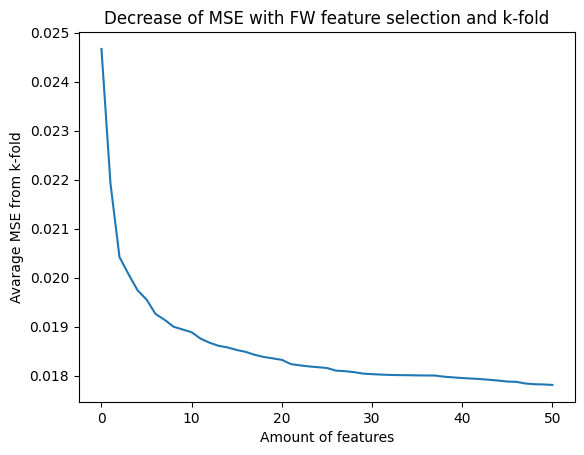

51

In [40]:
plt.plot(score)
plt.xlabel('Amount of features')
plt.ylabel('Avarage MSE from k-fold')
plt.title('Decrease of MSE with FW feature selection and k-fold')
plt.show()
len(selected)

Linear regression with all features; MSE: 0.018585900664078607, R2: 0.6722209658775409
Linear regression with all features; MSE: 0.018231326241189623, R2: 0.678474203961596


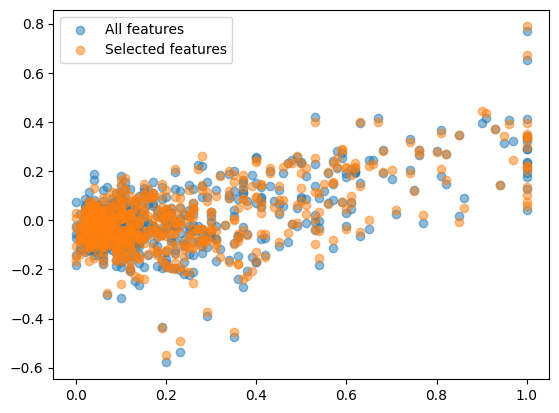

In [44]:
# Similar results with far less features
lr = LinearRegression().fit(x_train, y_train)
pred = lr.predict(x_test)
plt.scatter(y_test, y_test - pred, alpha=0.5)
print(f"Linear regression with all features; MSE: {mean_squared_error(y_test, pred)}, R2: {r2_score(y_test, pred)}")

lr = LinearRegression().fit(x_train[selected], y_train)
pred = lr.predict(x_test[selected])
plt.scatter(y_test, y_test - pred, alpha=0.5)
print(f"Linear regression with all features; MSE: {mean_squared_error(y_test, pred)}, R2: {r2_score(y_test, pred)}")
plt.legend(['All features', 'Selected features'])
plt.show()

Implement the bootstrap method and apply it to the train set to generate 1000 different train sets and train 1000 different linear models. Use only the attributes you selected before.

In [45]:
def bootstrap(n, m): # returns lists of indexes for n shuffeled (with possible repeated samples) sets
    bs_lists = []
    for _ in range(n):
        index_lists = []
        for _ in range(m):
            index_lists += [np.random.randint(m)]
        bs_lists.append(index_lists)
    return bs_lists

In [46]:
mse_bs = []
r2_bs = []
for row_list in bootstrap(1000, len(train)):
    tmp_train_x = x_train.loc[row_list]
    tmp_train_y = y_train.loc[row_list]

    lr = LinearRegression().fit(tmp_train_x[selected], tmp_train_y)
    pred = lr.predict(x_test[selected])
    mse_bs.append(mean_squared_error(y_test, pred))
    r2_bs.append(r2_score(y_test, pred))

Use the bootstrapped results to assess the confidence intervals of the results of the
linear model.

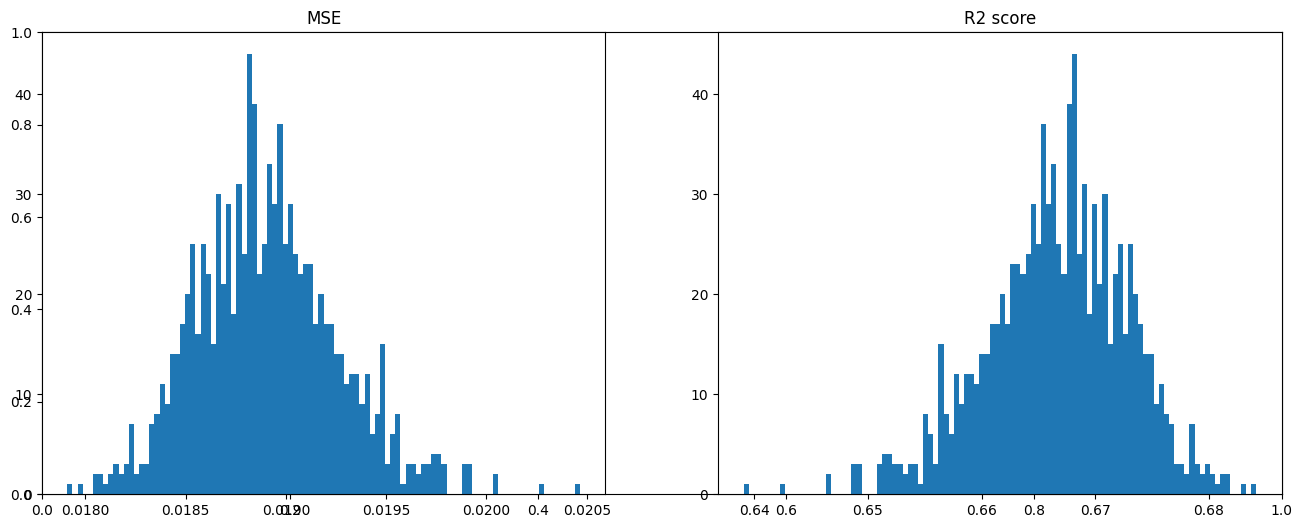

95th percentile of MSE: 0.01950505983023077,
95th percentile R2: 0.6757458955404931


In [47]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.subplot(1,2,1)
plt.hist(mse_bs, bins=100)
plt.title("MSE")
plt.subplot(1,2,2)
plt.hist(r2_bs, bins=100)
plt.title("R2 score")
plt.show()
ax.set_xticks([])
ax.set_yticks([])
print(f"95th percentile of MSE: {np.percentile(mse_bs, 95)},\n95th percentile R2: {np.percentile(r2_bs, 95)}")